# Natural Language Processing

In [1]:
# import all packages
import pandas as pd
import numpy as np
# Word cloud plots for Names
from wordcloud import WordCloud,ImageColorGenerator
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# LDA & LSI packages
import nltk
nltk.download('punkt')
import re
from gensim import models, corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import similarities
# Split dataset package
from sklearn.model_selection import train_test_split
# Random forest packages
from sklearn.feature_extraction.text import TfidfVectorizer as tfidfV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report as report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import string
#Evaluation on best model
from sklearn.metrics import precision_recall_fscore_support as f_score
from sklearn.metrics import accuracy_score as accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /Users/elainny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# import datasets

df = pd.read_csv('Data/cleaned-data.csv')
train = pd.read_csv('Data/cleaned-train.csv')
test = pd.read_csv('Data/cleaned-test.csv')

In [3]:
# fill out all NaN values under Description column with '-'
train = train[['Description','AdoptionSpeed']]
train['Descrption'] = train['Description'].fillna('-', inplace = True)

## Word Clouds

In [ ]:
# word cloud: cat name
plt.figure(figsize=(20, 8))
bg_pic = imread('dog-paw.png')
image_colors = ImageColorGenerator(bg_pic)


cat_name = ' '.join(df.loc[df['Type'] == 'Cat', 'Name'].fillna('').values)
wc_cat = WordCloud(mask=bg_pic,background_color='white',scale=20,max_words=300).generate(cat_name)

plt.imshow(wc_cat.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('cat.png')
plt.show()

In [ ]:
# word cloud: dog name
plt.figure(figsize=(20, 8))
dog_name = ' '.join(df.loc[df['Type'] == 'Dog', 'Name'].fillna('').values)
wc_dog = WordCloud(mask=bg_pic,background_color='white',scale=20,max_words=300).generate(dog_name)
plt.imshow(wc_dog.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('dog.png')
plt.show()

## LDA & LSI model

In [ ]:
# Create train_data by selecting Description columns in train data
train_data = train['Description'].values.tolist()

In [ ]:
# Define stopwords, lemmatizer, and data cleaning process
stop_words = set(stopwords.words("english"))
# Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# Stemming
stemming = nltk.PorterStemmer()


def cleandata(review) :
    clean_des = re.sub('[^a-zA-Z]', ' ', str(review)) # Remove punctuation/words not starting with alphabet
    clean_des = clean_des.lower() # make words lower cases
    words = word_tokenize(clean_des) # tokenize
    words = [w for w in words if not w in stop_words] # stop words removal
    words = [stemming.stem(word) for word in words] # Stemming
    words = [wordnet_lemmatizer.lemmatize(w) for w in words] #Lemmatize words
    return words

In [ ]:
# Define the number of topics
t = 10

cleaned = []
for description in train_data:
    cleaned.append(cleandata(description))
# Create a Dictionary associate word to id
D = corpora.Dictionary(cleaned)

# Transform texts to numeric
corpra = [D.doc2bow(i) for i in cleaned]

In [ ]:
# Build the LDA model
lda = models.LdaModel(corpus=corpra, num_topics=t, id2word=D)

print('LDA model')
for index in range(0,t):
    # top 9 topics
    print("Topic Number %s:" % str(index+1), lda.print_topic(index, 9))
print("-" * 117)

In [ ]:
# Build the LSI model
lsi = models.LsiModel(corpus=corpra, num_topics=t, id2word=D)

print('LSI model')
for index in range(0,t):
    # top 9 topics
    print("Topic Number %s:" % str(index+1), lsi.print_topic(index, 9))
print("-" * 117)

In [ ]:
# Randomly pick one description from test to predict similarity.
import random
i = random.randint(1,3948) # since my test dataset has 3498 values 
print(i)
test_data = test.loc[i,'Description']
print('-----This is the description from test that I am going to predict:-----')
print(test_data)

In [ ]:
# Compare LDA model and LSI model to predict similarity.
lda_i = similarities.MatrixSimilarity(lda[corpra])
m = D.doc2bow(cleandata(test_data))
# Perform some queries
similar_lda = lda_i[lda[m]]
# Sort the similarities
LDA = sorted(enumerate(similar_lda), key=lambda item: -item[1])
# Top 10 most similar documents:
print(LDA[:10])
# The most similar document
doc_id, similarity = LDA[1]
print(train_data[doc_id][:100])

In [ ]:
# Do the same similarity queries by using LSI model
lsi_i = similarities.MatrixSimilarity(lsi[corpra])
similar_lsi = lsi_i[lsi[m]]
LSI = sorted(enumerate(similar_lsi), key=lambda item:-item[1])
print(LSI[:10])
doc_id_lsi, similarity_lsi = LSI[1]
print(train_data[doc_id][:100])

## Multinomial -- first try on prediction

In [4]:
# Choose the correct columns
trainMB = train[['Description','AdoptionSpeed']]
train_null = np.array(trainMB[trainMB['Description'].isnull() == True].index)
trainMB = train.drop(train_null)

In [6]:
# Split the X and Y data into train and valid:

X_train, X_valid, Y_train, Y_valid = train_test_split(trainMB['Description'], trainMB['AdoptionSpeed'], 
                                                      test_size=.2, random_state=12)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((11994,), (2999,), (11994,), (2999,))

In [7]:
# Define data cleaning process(tokenize, lower cases, lemmatizer) for random forest
# and apply data cleaning on X_train and X_valid

wordnet_lemmatizer = WordNetLemmatizer() # same as LDA and LSI but do not remove stop words

def nlp_rf(reviews):
    token = [word_tokenize(i) for i in reviews]
    token1 = [[d.lower() for d in words if d.isalpha() == True] for words in token]
    lemma = [[wordnet_lemmatizer.lemmatize(word) for word in doc] for doc in token1]
    review = [" ".join(i) for i in lemma]
    return review

In [18]:
# Apply data cleaning on X_train and X_valid

X_train_clean = nlp_rf(X_train)
X_valid_clean = nlp_rf(X_valid)

In [19]:
# Machine Learning models on Description
from sklearn.linear_model import SGDClassifier
tfvec = tfidfV(stop_words='english', ngram_range=(1, 1), lowercase=False)
model = Pipeline([('vectorizer', tfvec),('rf', MultinomialNB(alpha=0.0))])

In [20]:
# Y_pred and report
model.fit(X_train_clean, Y_train)
Y_prediction = model.predict(X_valid_clean)
print(report(Y_valid, Y_prediction))

             precision    recall  f1-score   support

          0       0.50      0.08      0.14        85
          1       0.36      0.24      0.29       656
          2       0.34      0.38      0.36       823
          3       0.31      0.27      0.29       652
          4       0.38      0.51      0.44       783

avg / total       0.35      0.35      0.34      2999



/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


## NLP for Machine Learning -- choose the best model

Notice: Here, I choose the first 7000 rows to calcualte best model, since it needs at least 2 hours to run the code if I choose the whole dataset. To run the whole dataset, I connect to AWS and run it through aws ubuntu, and the code is inside the nlp2.py

In [11]:
# Import package: string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
# Select the first 7000 rows to do this, since there are 14993 rows, which needs plenty of time to run
train7000 = train[:7000]
train7000.tail()

,Description,AdoptionSpeed,Descrption
6995,"Healthy stray mother living at our area, gave ...",4,None
6996,I adopted a stray unspayed female. Before we m...,0,None
6997,I found 12 cute puppies. And putting it on adp...,4,None
6998,Skywalker is a playful and happy boy. He was r...,1,None
6999,"Lovey is gentle, super loving and affectionate...",1,None


In [14]:
# apply puctuation removal, tokenize, stopwords removal, stemming and lemmatizer
# I use the same cleandata function as LDA/LSI model
# define stopwords, lemmatizer, and data cleaning process
stop_words = set(stopwords.words("english"))
# Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# Stemming
stemming = nltk.PorterStemmer()


def cleandata(review) :
    clean_des = re.sub('[^a-zA-Z]', ' ', str(review)) # Remove punctuation/words not starting with alphabet
    clean_des = clean_des.lower() # make words lower cases
    words = word_tokenize(clean_des) # tokenize
    words = [w for w in words if not w in stop_words] # stop words removal
    words = [stemming.stem(word) for word in words] # Stemming
    words = [wordnet_lemmatizer.lemmatize(w) for w in words] #Lemmatize words
    return words

I comment out the following code since they are used to create bag-of-words. If only wanted to check bag-of-words, uncomment the following 4 parts.

In [ ]:
# Apply CountVectorizer: N-Grams
# Do the 2-gram
#cv_vectorizer = CountVectorizer(ngram_range=(2,2),analyzer=cleandata)
#X_cv = cv_vectorizer.fit_transform(train7000['Description'])
#print(X_cv.shape)
#print(cv_vectorizer.get_feature_names())

In [ ]:
#Xdf_cv = pd.DataFrame(X_cv.toarray(), columns=cv_vectorizer.get_feature_names())
#Xdf_cv.head(10)

In [ ]:
# TF-IDF
#tfidf_vectorizer = tfidfV(analyzer=cleandata)
#X_tfidf = tfidf_vectorizer.fit_transform(train7000['Description'])
#print(X_tfidf.shape)
#print(tfidf_vectorizer.get_feature_names())

In [ ]:
#Xdf_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
#Xdf_tfidf.head(10)

In [21]:
# Build Machine Learning Classifiers with Random Forest model and GridSearchCV
# Need to calculate the length and punctuation percentage of each description
# 1st: calculate length of message without counting space in
train7000['length'] = train7000['Description'].apply(lambda length: len(length) - length.count(" "))

#2nd: function of puncutuation number to apply on every description
def punct_percentage(description):
    count = sum([1 for symbol in description if symbol in string.punctuation]) # string.punctuation defined above
    return 100 * round(count/(len(description) - description.count(" ")), 3)

train7000['punctuation-percentage'] = train7000['Description'].apply(lambda des: punct_percentage(des))

train7000.head()

/Users/elainny/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/elainny/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Description,AdoptionSpeed,Descrption,length,punctuation-percentage
0,Nibble is a 3+ month old ball of cuteness. He ...,2,None,291,2.7
1,I just found it alone yesterday near my apartm...,0,None,96,2.1
2,Their pregnant mother was dumped by her irresp...,3,None,325,2.8
3,"Good guard dog, very alert, active, obedience ...",2,None,122,5.7
4,This handsome yet cute boy is up for adoption....,2,None,310,2.9


In [22]:
# Exploring parameters using GridSearchCV
# TF-IDF
tfidf_vectorizer = tfidfV(analyzer=nlp_rf)
X_tfidf = tfidf_vectorizer.fit_transform(train7000['Description'])
X_tfidf_clf = pd.concat([train7000['length'], train7000['punctuation-percentage'], 
                         pd.DataFrame(X_tfidf.toarray())], axis=1)

# CountVectorizer
cv_vectorizer = CountVectorizer(ngram_range=(2,2),analyzer=nlp_rf)
X_cv = cv_vectorizer.fit_transform(train7000['Description'])
X_cv_clf = pd.concat([train7000['length'], train7000['punctuation-percentage'], 
                                   pd.DataFrame(X_cv.toarray())], axis=1)

/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [23]:
# For CountVectorizer
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs_cv = GridSearchCV(rf, param, cv=5, n_jobs=-1)# n_jobs=-1 for parallelizing search
gs_cv_fit = gs_cv.fit(X_cv_clf, train7000['AdoptionSpeed'])
pd.DataFrame(gs_cv_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,19.156626,1.259407,0.263839,0.034347,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.325963,0.328337,0.367857,...,0.340000,0.015011,1,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
11,13.306323,1.443329,0.155519,0.015791,None,300,"{'max_depth': None, 'n_estimators': 300}",0.318117,0.324768,0.367143,...,0.338429,0.016966,2,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
5,19.657386,0.382202,0.365701,0.033279,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.330243,0.336188,0.368571,...,0.336857,0.016485,3,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
4,9.358041,0.126694,0.161488,0.013566,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.309558,0.329764,0.372143,...,0.334571,0.020464,4,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
1,9.008280,0.086497,0.153278,0.007507,30,150,"{'max_depth': 30, 'n_estimators': 150}",0.325963,0.321199,0.365714,...,0.332571,0.016734,5,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521


The mean_test_score for n_estimators =300 and max_depth = 60 gives the best result. Where n_estimators is the number of trees in the forest.(group of decision trees) and max_depth is the max number of levels in each decision tree.

In [24]:
# For TF-IDF
gs_tfidf = GridSearchCV(rf, param, cv=5, n_jobs=-1)# n_jobs=-1 for parallelizing search
gs_tfidf_fit = gs_tfidf.fit(X_tfidf_clf, train7000['AdoptionSpeed'])
pd.DataFrame(gs_tfidf_fit.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,18.983153,0.083776,0.292527,0.009009,60,300,"{'max_depth': 60, 'n_estimators': 300}",0.336662,0.337616,0.354286,...,0.342857,0.006271,1,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
10,9.911890,0.094913,0.170341,0.014115,None,150,"{'max_depth': None, 'n_estimators': 150}",0.349501,0.319058,0.357143,...,0.339286,0.013536,2,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
8,19.154111,0.062707,0.304214,0.010391,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.345221,0.330478,0.352143,...,0.339143,0.008315,3,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
11,17.915041,0.454870,0.270713,0.010357,None,300,"{'max_depth': None, 'n_estimators': 300}",0.339515,0.341899,0.347857,...,0.337286,0.008366,4,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521
2,18.076963,0.060859,0.273858,0.005183,30,300,"{'max_depth': 30, 'n_estimators': 300}",0.330956,0.328337,0.352143,...,0.335571,0.011193,5,0.978921,0.978925,0.979286,0.977861,0.978222,0.978643,0.000521


The mean_test_score for n_estimators =300  and max_depth = None gives the best result. Where n_estimators is the number of trees in the forest.(group of decision trees) and max_depth is the max number of levels in each decision tree.

### Classifier and evaluating

In [25]:
# Split the dataset
X=train7000[['Description', 'length', 'punctuation-percentage']]
y=train7000['AdoptionSpeed']

X_train7000, X_test7000, y_train7000, y_test7000 = train_test_split(X,y, test_size=0.1, random_state=42)
X_train7000.shape, X_test7000.shape, y_train7000.shape, y_test7000.shape

((6300, 3), (700, 3), (6300,), (700,))

In [26]:
# Evaluation of model: on tfidf
# Variables define
tfidf_vectorizer7000 = tfidfV(analyzer=cleandata) # defined before
tfidf_fit7000 = tfidf_vectorizer7000.fit(X_train7000['Description'])

tfidf_train7000 = tfidf_fit7000.transform(X_train7000['Description'])
tfidf_test7000 = tfidf_fit7000.transform(X_test7000['Description'])

X_vectorizer_train7000 = pd.concat([X_train7000[['length', 'punctuation-percentage']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train7000.toarray())], axis=1)
X_vectorizer_test7000 = pd.concat([X_test7000[['length', 'punctuation-percentage']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test7000.toarray())], axis=1)

# Build model
rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_vectorizer_train7000, y_train7000)
y_prediction1 = rf_model.predict(X_vectorizer_test7000)

precision, recall, fscore, train_support = f_score(y_test7000, y_prediction1, pos_label='spam', average='micro')
print('Precision: {} --- Recall: {} --- F1-Score: {} --- Accuracy: {}'.format(
    round(precision, 2), round(recall, 2), round(fscore,2), round(accuracy(y_test7000,y_prediction1), 2)))

/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Precision: 0.4 --- Recall: 0.4 --- F1-Score: 0.4 --- Accuracy: 0.4


/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to 'spam') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [27]:
print(report(y_test7000, y_prediction1))

             precision    recall  f1-score   support

          0       1.00      0.06      0.12        16
          1       0.41      0.15      0.22       139
          2       0.40      0.45      0.42       202
          3       0.43      0.21      0.28       147
          4       0.38      0.68      0.49       196

avg / total       0.42      0.40      0.36       700



/Users/elainny/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


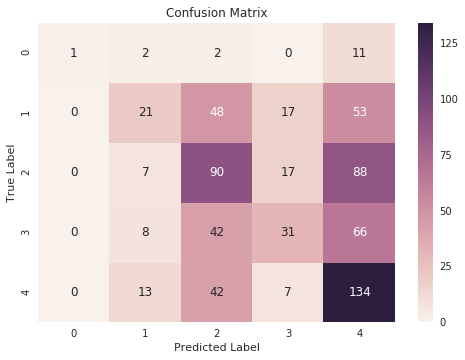

In [28]:
# Making the Confusion Matrix: tfidf
matrix = confusion_matrix(y_test7000, y_prediction1)
class_label = ['0','1','2','3','4']
matrix_df = pd.DataFrame(matrix, index=class_label,columns=class_label)
sns.heatmap(matrix_df, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [29]:
# Evaluation of model: on CountVectorizer
# Variables define
cv7000 = CountVectorizer(ngram_range=(2,2),analyzer=cleandata) # defined before
cv_fit7000 = cv7000.fit(X_train7000['Description'])

cv_train7000 = cv_fit7000.transform(X_train7000['Description'])
cv_test7000 = cv_fit7000.transform(X_test7000['Description'])

X_cv_train7000 = pd.concat([X_train7000[['length', 'punctuation-percentage']].reset_index(drop=True), 
           pd.DataFrame(cv_train7000.toarray())], axis=1)
X_cv_test7000 = pd.concat([X_test7000[['length', 'punctuation-percentage']].reset_index(drop=True), 
           pd.DataFrame(cv_test7000.toarray())], axis=1)

# Build model
rf_cv = RandomForestClassifier(n_estimators=300, max_depth=60, n_jobs=-1)
rf_model_cv = rf_cv.fit(X_cv_train7000, y_train7000)
y_prediction_cv = rf_model_cv.predict(X_cv_test7000)

precision, recall, fscore, train_support = f_score(y_test7000, y_prediction_cv, pos_label='spam', average='micro')
print('Precision: {} --- Recall: {} --- F1-Score: {} --- Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(accuracy(y_test7000,y_prediction_cv), 3)))

Precision: 0.404 --- Recall: 0.404 --- F1-Score: 0.404 --- Accuracy: 0.404


/Users/elainny/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1045: UserWarning: Note that pos_label (set to 'spam') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [30]:
print(report(y_test7000, y_prediction_cv))

             precision    recall  f1-score   support

          0       1.00      0.06      0.12        16
          1       0.51      0.13      0.21       139
          2       0.43      0.39      0.41       202
          3       0.46      0.20      0.28       147
          4       0.37      0.80      0.51       196

avg / total       0.45      0.40      0.36       700



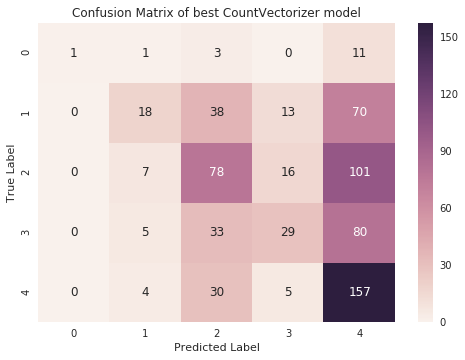

In [31]:
# Making the Confusion Matrix: CountVectorizer
matrixcv = confusion_matrix(y_test7000, y_prediction_cv)
class_label = ['0','1','2','3','4']
matrixcv_df = pd.DataFrame(matrixcv, index=class_label,columns=class_label)
sns.heatmap(matrixcv_df, annot=True, fmt='d')
plt.title("Confusion Matrix of best CountVectorizer model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()